In [1]:
import matplotlib.pyplot as plt

In [2]:
# Crear carpeta data del proyecto
import os

os.makedirs("data", exist_ok=True)


print("Estructura creada")

Estructura creada


In [3]:
# Proyecto: Análisis de Opinión en Repositorios Git
# Curso: Procesamiento de Lenguaje Natural
# Integrantes:
# - Bermúdez Pinargote Glenda Mariuxi
# - Marcillo Moncayo Elvis Alejandro
# - Valdez Loor Lady Lissette


print("Proyecto iniciado correctamente")

Proyecto iniciado correctamente


**# RF-01 Recolección de datos**


In [4]:
import requests
import pandas as pd

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [5]:
# 1 Extraer owner y repo desde URL
def extraer_owner_repo(url):
    partes = url.rstrip("/").split("/")
    owner = partes[-2]
    repo = partes[-1]
    return owner, repo

In [6]:
# 2 Recolectar issues, PRs y comentarios
def recolectar_datos_github(owner, repo, token=None, max_items=100):

    headers = {}
    if token:
        headers["Authorization"] = f"token {token}"

    url = f"https://api.github.com/repos/{owner}/{repo}/issues"
    params = {
        "state": "all",     # abiertos y cerrados
        "per_page": 96     # máximo permitido por la API
    }

    response = requests.get(url, headers=headers, params=params)

    # Control básico de error
    if response.status_code != 200:
        print("Error en la API:", response.status_code)
        return []

    issues = response.json()
    datos = []

    # Limitar manualmente por seguridad
    for item in issues[:max_items]:

        tipo = "pull_request" if "pull_request" in item else "issue"
        numero = item["number"]

        datos.append({
            "tipo": tipo,
            "numero": numero,
            "titulo": item["title"],
            "texto": item["body"] if item["body"] else ""
        })

        # Recolectar comentarios asociados
        if item.get("comments", 0) > 0:
            comentarios = requests.get(item["comments_url"], headers=headers)

            if comentarios.status_code == 200:
                for c in comentarios.json():
                    datos.append({
                        "tipo": "comment",
                        "numero": numero,
                        "titulo": "",
                        "texto": c["body"]
                    })

    return datos



In [7]:
# 3 Ejecutar recolección
repo_url = "https://github.com/scikit-learn/scikit-learn"
owner, repo = extraer_owner_repo(repo_url)

datos = recolectar_datos_github(owner, repo, max_items=96)

print("Total registros recolectados:", len(datos))

Total registros recolectados: 100


In [8]:
# 4 Guardar dataset
import pandas as pd
df = pd.DataFrame(datos)
df.to_csv("data/mensajes.csv", index=False, encoding="utf-8")

print("CSV guardado correctamente")
print(df["tipo"].value_counts())

CSV guardado correctamente
tipo
pull_request    71
issue           25
comment          4
Name: count, dtype: int64


**# RF-02 Preprocesamiento de texto**

In [9]:
# 1 Importaciones de librerias
import pandas as pd
import re
import unicodedata
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [10]:
# 2 Descargar recursos necesarios
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# 3 Cargar dataset generado en RF-01
df = pd.read_csv("data/mensajes.csv")
df.head()


,tipo,numero,titulo,texto
0,issue,33266,⚠️ CI failed on Unit tests Linux x86-64 pymin_...,**CI failed on [Unit tests Linux x86-64 pymin_...
1,issue,33265,🚀 Feature Request: Integrate `RkCNN` (Random k...,### Describe the workflow you want to enable\n...
2,pull_request,33264,MNT remove unused function in PowerTransformer,#### Reference Issues/PRs\r\nNone\r\n\r\n#### ...
3,pull_request,33263,Add array API support for `FeatureUnion`,"While working on an array API demo, I realized..."
4,pull_request,33262,Fix the eigsh call in spectral embedding,Fixes #33242 \r\n\r\nThis fixes the way `eigsh...


In [12]:
# 4 Definir recursos lingüísticos
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [13]:
# 5 Función de limpieza
def limpiar_texto(texto):
    if pd.isna(texto):
        return ""

    # 1.Pasar a minúsculas
    texto = texto.lower()

    # 2.Eliminar bloques HTML
    texto = re.sub(r"<.*?>", "", texto)

    # 3.Eliminar plantillas comunes de GitHub
    texto = re.sub(r"ai usage disclosure.*", "", texto, flags=re.DOTALL)
    texto = re.sub(r"thanks for contributing.*", "", texto)
    texto = re.sub(r"reference issues/prs.*", "", texto)

    # 4.Normalizar acentos
    texto = unicodedata.normalize("NFKD", texto)\
           .encode("ascii", "ignore")\
           .decode("utf-8")

    # 5.Eliminar URLs
    texto = re.sub(r"http\S+|www\S+", "", texto)

    # 6.Eliminar caracteres no alfabéticos
    texto = re.sub(r"[^a-z\s]", "", texto)

    # 7.Tokenización
    tokens = word_tokenize(texto)

    # 8.Eliminar stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # 9.Lematización
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


In [14]:
# 6 Aplicar limpieza

df["texto_limpio"] = df["texto"].apply(limpiar_texto)
df.head(5)

,tipo,numero,titulo,texto,texto_limpio
0,issue,33266,⚠️ CI failed on Unit tests Linux x86-64 pymin_...,**CI failed on [Unit tests Linux x86-64 pymin_...,ci failed unit test linux x pymincondaforgeope...
1,issue,33265,🚀 Feature Request: Integrate `RkCNN` (Random k...,### Describe the workflow you want to enable\n...,describe workflow want enable summary issue pr...
2,pull_request,33264,MNT remove unused function in PowerTransformer,#### Reference Issues/PRs\r\nNone\r\n\r\n#### ...,none implementfix explain change pr remove unu...
3,pull_request,33263,Add array API support for `FeatureUnion`,"While working on an array API demo, I realized...",working array api demo realized featureunion s...
4,pull_request,33262,Fix the eigsh call in spectral embedding,Fixes #33242 \r\n\r\nThis fixes the way `eigsh...,fix fix way eigsh called spectral embedding re...


In [15]:
df.columns

Index(['tipo', 'numero', 'titulo', 'texto', 'texto_limpio'], dtype='object')

**# RF-03 Representación TF-IDF**

In [16]:
from nltk import ngrams

In [17]:
texto = ' '.join(df['texto_limpio'].astype(str))
print(texto)

ci failed unit test linux x pymincondaforgeopenblasmindependencies feb testregressionsynthetic describe workflow want enable summary issue proposes integrating random k conditional nearest neighbor rkcnn described peerj computer science fully scikitlearncompliant estimator interface enabling seamless use pipeline crossvalidation hyperparameter tuning paper reference implementation author motivation nearest neighbor method degrade highdimensional setting due irrelevantnoisy feature rkcnn address sampling multiple random feature subset training kcnn model subset computing separation score betweenclass withinclass variance ratio weighting filtering subset based discriminative power aggregating prediction via weighted probability averaging approach improves robustness highdimensional problem eg gene expression embeddings sparse feature maintaining simplicity interpretability knnstyle classifier however current implementation fully adhere modern scikitlearn api standard lack strict estimato

In [18]:
tokens = word_tokenize(texto)
print("Tokens:", tokens[:10])

Tokens: ['ci', 'failed', 'unit', 'test', 'linux', 'x', 'pymincondaforgeopenblasmindependencies', 'feb', 'testregressionsynthetic', 'describe']


In [19]:
bigrams = list(ngrams(tokens, 2))

In [20]:
for g in bigrams[:10]:
  print("Bigrama:", g)

Bigrama: ('ci', 'failed')
Bigrama: ('failed', 'unit')
Bigrama: ('unit', 'test')
Bigrama: ('test', 'linux')
Bigrama: ('linux', 'x')
Bigrama: ('x', 'pymincondaforgeopenblasmindependencies')
Bigrama: ('pymincondaforgeopenblasmindependencies', 'feb')
Bigrama: ('feb', 'testregressionsynthetic')
Bigrama: ('testregressionsynthetic', 'describe')
Bigrama: ('describe', 'workflow')


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(df['texto_limpio'])

print("Matriz TF-IDF (sparse):", X.shape)

Matriz TF-IDF (sparse): (100, 7925)


**# RF-04 Análisis de sentimiento**

In [22]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")  # necesario para VADER

sia = SentimentIntensityAnalyzer()

texto = "Fixed the bug in the preprocessing step"
scores = sia.polarity_scores(texto)
print(scores)


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
def etiqueta_sentimiento_vader(texto):
    scores = sia.polarity_scores(texto)
    if scores['compound'] >= 0.3:
        return 'positivo'
    elif scores['compound'] <= -0.3:
        return 'negativo'
    else:
        return 'neutral'

df['sentimiento'] = df['texto_limpio'].apply(etiqueta_sentimiento_vader)


In [24]:
df['sentimiento'].unique()

array(['negativo', 'positivo', 'neutral'], dtype=object)

In [25]:
y = df['sentimiento']

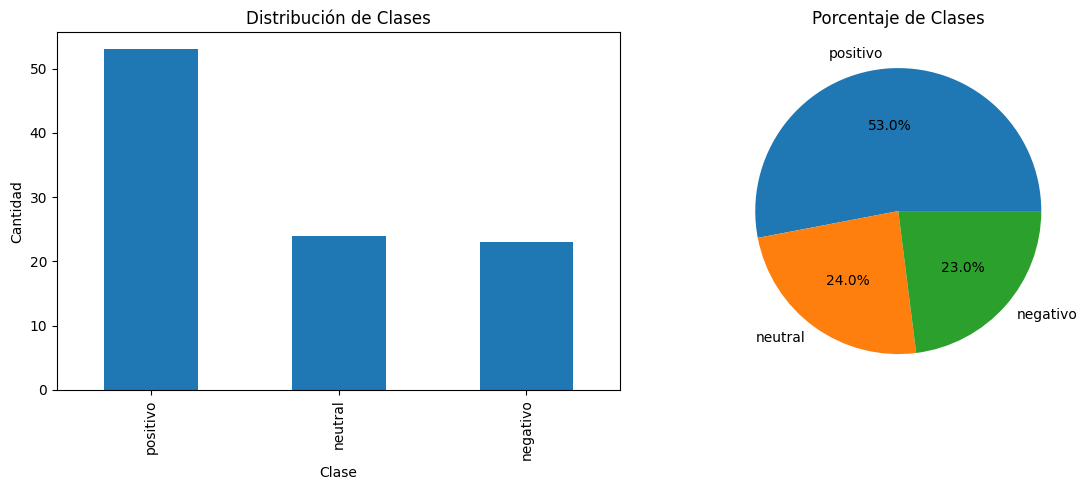

Conteo de clases:
sentimiento
positivo    53
neutral     24
negativo    23
Name: count, dtype: int64


In [26]:
class_counts = df['sentimiento'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

class_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribución de Clases')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

class_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes[1],
)
axes[1].set_ylabel('')
axes[1].set_title('Porcentaje de Clases')

plt.tight_layout()
plt.show()

print("Conteo de clases:")
print(class_counts)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LinearSVC(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-macro:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.75
F1-macro: 0.653639846743295


**# RF-05 Identificación de temas**

In [28]:
from sklearn.cluster import KMeans
import numpy as np

# Agrupamiento K-Means
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
df["tema"] = kmeans.fit_predict(X)

print("Distribución de temas:")
print(df["tema"].value_counts())

# Mostrar palabras clave de cada tema
terms = vectorizer.get_feature_names_out()
for i in range(k):
    centroid = kmeans.cluster_centers_[i]
    top = centroid.argsort()[-10:][::-1]
    print(f"\nTema {i}: " + ", ".join(terms[t] for t in top))

Distribución de temas:
tema
0    41
2    38
3    14
1     7
Name: count, dtype: int64

Tema 0: describe, import, response, line, none, file, python, score, change, class

Tema 1: branch, note ci, based pr, new branch, file note, ci task, create new, branch based, required fix, fix branch

Tema 2: pull, pull request, see, request, test, change, pr, fix, please, also

Tema 3: link, example, towards, docstring, pr add, help user, class, class docstring, add link, example demonstrates


**RF–06 Similitud textual**

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def mensajes_mas_similares(indice, top_n=5):

    # Calcular similitud contra todos
    similitudes = cosine_similarity(X[indice], X).flatten()

    # Excluir el mismo mensaje
    similitudes[indice] = -1

    # Obtener índices ordenados
    indices = np.argsort(similitudes)[-top_n:][::-1]

    # Mostrar mensaje original
    print("\n" + "="*90)
    print(" MENSAJE ORIGINAL:\n")
    print(df.loc[indice, "texto"])
    print("="*90 + "\n")

    # Mostrar similares uno por uno
    for pos, i in enumerate(indices, 1):
        print(f"🔹 Mensaje similar #{pos}")
        print(f"   ➤ Tipo: {df.loc[i, 'tipo']}")
        print(f"   ➤ Similitud: {(similitudes[i]*100):.2f}%\n")
        print("   Texto:")
        print(df.loc[i, "texto"])
        print("\n" + "-"*90 + "\n")


In [30]:
mensajes_mas_similares(2, top_n=5)


 MENSAJE ORIGINAL:

#### Reference Issues/PRs
None

#### What does this implement/fix? Explain your changes.
This PR removes an unused function in class PowerTransformer.

#### AI usage disclosure
None

🔹 Mensaje similar #1
   ➤ Tipo: pull_request
   ➤ Similitud: 25.47%

   Texto:
#### Reference Issues/PRs
Follow-up of PR #29477 / issue #20813.

#### What does this implement/fix? Explain your changes.
This PR removes some leftover author names.

#### AI usage disclosure
No.

#### Any other comments?
Remaining are:
- `sklearn.utils.optimize.py` (kind of a license redistribution notice)

------------------------------------------------------------------------------------------

🔹 Mensaje similar #2
   ➤ Tipo: pull_request
   ➤ Similitud: 18.65%

   Texto:
#### Reference Issues/PRs
None

#### What does this implement/fix? Explain your changes.
Small addition or clarification for the D2 Brier score.

#### AI usage disclosure
None

#### Any other comments?
None

---------------------------